# SemEval 2020 Task 12: OffensEval2

## Installing packages

In [0]:
# Install necessary packages

!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install -U symspellpy
!pip install emoji --upgrade
!pip install -U imbalanced-learn

     |████████████████████████████████| 245kB 3.4MB/s 
     |████████████████████████████████| 317kB 4.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81705 sha256=4db77fbd4740b84d6dc025f9c872bdce34aa0bb6572ca1cf1183f757e325428e
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 4.8MB 3.1MB/s 
     |████████████████████████████████| 2.6MB 3.5MB/s 
     |████████████████████████████████| 51kB 1.9MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=5e725ebc2f211ef97b86089ca3e2cb84d519c18d159ff83724d6cfee061ba85d
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 163kB 3.5MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imba

### Mounting drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
PATH_TO_DIR = '/content/drive/My Drive/STUDIA/SEM 9/pracownia/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data preprocessing

In [0]:
# All imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import emoji
from imblearn.over_sampling import SMOTE

wordsegment.load()

# Load SymSpell -> package for correcting misspellings
sym_spell = SymSpell(2, 7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

Using TensorFlow backend.


True

In [0]:
#Import data
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
print(training_dataset.head())
test_tweets_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/testset-levela.tsv'
test_tweets = pd.read_csv(test_tweets_url, delimiter='\t')
print(test_tweets.head())
test_labels_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/labels-levela.csv'
test_labels = pd.read_csv(test_labels_url, delimiter=',', header=None, names=["id", "label"])
print(test_labels.head())
test_dataset = test_tweets.set_index("id").join(test_labels.set_index("id"))
test_dataset.head()

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]
      id                                              tweet
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1  27014  #ConstitutionDay is revered by Conservatives, ...
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3  13876  #Watching #Boomer getting the news that she is...
4  60133  #NoPasaran: Unity demo to oppose the far-right...
      id label
0  15923   OFF
1  27014   NOT
2  30530   NOT
3  13876   NOT
4  60133   OFF


,tweet,label
id,,
15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
13876,#Watching #Boomer getting the news that she is...,NOT
60133,#NoPasaran: Unity demo to oppose the far-right...,OFF


In [0]:
seed = 13

# prepare training examples
training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# prepare test examples and labels
test_examples_A = test_dataset['tweet'][test_dataset['label'].notnull()]
test_labels_A = (test_dataset['label'][test_dataset['label'].notnull()] == 'OFF').astype(int)

# prepare training labels
training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# split training set into training and validation
training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
    training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A, random_state=seed)
training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
    training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B, random_state=seed)
training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
    training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C, random_state=seed)

training_x = list(training_examples_A)
validation_x = list(validation_examples_A)
training_y = list(training_labels_A)
validation_y = list(validation_labels_A)
test_x = list(test_examples_A)
test_y = list(test_labels_A)

## **Preprocessing** (used as alternative to albert preprocessing)

### Common preprocessing functions

In [0]:
# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


def preprocess_common(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    return text.lower()

In [0]:
# Remove redundant @user tokens
def remove_redundant_users(example):
  user_count = 0
  new_example = example[:]
  for i, token in reversed(list(enumerate(example))):
    if token == '@user':
      user_count += 1
      if user_count > 3:
        new_example.pop(i)

    else:
      user_count = 0

  return new_example



### Spacy preprocessing

In [0]:
nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def preprocess_spacy(text):
    text = text.lower()
    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # correct misspelings
        # if flag == True:
        #     suggestions = sym_spell.lookup(edit, Verbosity.TOP, 2)
        #     if len(suggestions) > 0:
        #         edit = suggestions[0].term

        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_

        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text

### Joint preprocessing

In [0]:
def full_preprocessing(example):
    basic_preprocessed = preprocess_common(example)
    cleaned_example = preprocess_spacy(basic_preprocessed)
    return remove_redundant_users(cleaned_example)

### Preprocessing execution

In [0]:
# normalization -> papers, complicated solutions, replace abbreviations with full names (e.g. MAGA)
# check removing less stop words (some may have some significance)

cleaned_x = [full_preprocessing(example) for example in training_x[0:30]]
print(cleaned_x[0:30])
print(training_x[0:30])

[['@user', '@user', '@user', 'know', 'belong', 'violent', 'liberal', 'antifa', 'party', 'w/', 'kkk', 'hood', 'beat', 'total', 'stranger', '&', 'fund', 'party', 'violent', '&', 'corrupt', 'party', 'try', 'pour', 'tear', '&', 'believe', 'heart', 'hard', 'sell', 'include', 'voter'], ['@user', 'lie', 'corrupt', 'traitor', 'nobody', 'want', 'hear', 'anymore', 'lie', 'deep', 'state', 'corruption', 'url'], ['@user', '@user', 'typical', 'liberal', 'principle', 'come', 'money'], ['@user', 'know', 'add', 'million', '@user', 'donation', 'receive', 'access'], ['@user', 'idiot', 'fringe', 'right', 'hate', 'conservative'], ['@user', '@user', '@user', 'think', 'conservative', 'one', 'try', 'rewrite', 'history', 'think', 'face', 'url'], ['@user', '@user', '@user', 'link', 'article', 'show', 'wrong', 'tell', 'libertarian', 'conservative', 'aka', 'right', 'supposedly', 'believe', 'not', 'bigote', 'pattern', 'notice', 'never', 'wrong'], ['@user', 'grit', 'tooth', 'blonde', 'break', 'shield', 'feeling', '

In [0]:
preprocessed_train = [full_preprocessing(example) for example in training_x]
preprocessed_valid = [full_preprocessing(example) for example in validation_x]
preprocessed_test = [full_preprocessing(example) for example in test_x]

### Class imbalance

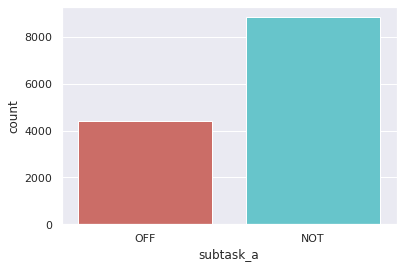

subtask_a
NOT    8840
OFF    4400
Name: id, dtype: int64


In [0]:
#Depict class imbalance for the subtask A
sns.set(font_scale=1.0)
countplt=sns.countplot(x='subtask_a', data=training_dataset, palette ='hls')
plt.show()

print(training_dataset.groupby('subtask_a').count()['id'])

## Helper functins

In [0]:
def get_model_checkpoint(name):
    return ModelCheckpoint(PATH_TO_DIR + 'models/' + name,
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

In [0]:
def plot_history(history):
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(history.history['precision_m'])
    plt.plot(history.history['val_precision_m'])
    plt.title('Precision')
    plt.legend(['train', 'val'], loc='upper left')

    plt.figure(figsize=(12, 12))
    plt.plot(history.history['recall_m'])
    plt.plot(history.history['val_recall_m'])
    plt.title('Recall')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(history.history['f1_m'])
    plt.plot(history.history['val_f1_m'])
    plt.title('F1')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.show()

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(training_y),
                                            training_y)
class_weights /= max(class_weights)
class_weights

array([0.49773756, 1.        ])

In [0]:
def weighted_loss(actual, predicted):
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = bce(actual, predicted)
   
    return tf.keras.backend.mean(loss * class_weights)

## Albert

### Our preprocessing

In [0]:
def remove_punctation(tokens):
    punctuation = [char for char in string.punctuation]
    return list(filter(lambda token: token not in punctuation, tokens))


def preprocess_bert_before_tokenization(text):
    cleaned_x = preprocess_common(text)
    # spacy_x = preprocess_spacy(preprocessed_text)
    # cleaned_x = remove_redundant_users(spacy_x)
    return cleaned_x


def preprocess_bert_after_tokenization(tokenized_x):
    # update input_ids, input_mask, input_type_ids
    return remove_punctation(cleaned_x) # remove i.a. hyphens remainings from words like 'de-platforming'

In [0]:
training_x[:10]

['@USER @USER @USER We do know she belongs to the violent liberal Antifa party who w/ their KKK HOODS beat up total strangers &amp; are funded to do so by her party. Most violent &amp; corrupt party trying to now pour on the tears &amp; get us to believe they have a heart. Hard sell to anyone including voters!',
 '@USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL',
 '@USER @USER Typical liberals. Principled until it comes to their money.',
 '@USER Because she knew how to add up the millions in @USER donations received for access?',
 '@USER Those idiots are fringe right. They are hated by most conservatives.',
 '@USER @USER @USER I thought conservatives were the ones trying to rewrite history? 🤔 URL',
 '@USER @USER @USER I linked to an article showing you why you\'re wrong. You\'re telling libertarians and conservatives" aka the right what they supposedly believe. I\'m not bigoted, it\'s just a pattern I\'ve noticed that never

In [0]:
preprocessed_train = [preprocess_bert_before_tokenization(example) for example in training_x]
preprocessed_valid = [preprocess_bert_before_tokenization(example) for example in validation_x]
preprocessed_test = [preprocess_bert_before_tokenization(example) for example in test_x]

In [0]:
preprocessed_train[:10]

['@user @user @user we do know she belongs to the violent liberal antifa party who w/ their kkk hoods beat up total strangers & are funded to do so by her party. most violent & corrupt party trying to now pour on the tears & get us to believe they have a heart. hard sell to anyone including voters!',
 '@user you are a lying corrupt traitor!!! nobody wants to hear anymore of your lies!!! deep state corruption url',
 '@user @user typical liberals. principled until it comes to their money.',
 '@user because she knew how to add up the millions in @user donations received for access?',
 '@user those idiots are fringe right. they are hated by most conservatives.',
 '@user @user @user i thought conservatives were the ones trying to rewrite history? thinking face url',
 '@user @user @user i linked to an article showing you why you are wrong. you are telling libertarians and conservatives" aka the right what they supposedly believe. i am not bigoted, it is just a pattern i have noticed that nev

### Albert preprocessing

In [0]:
! pip install bert-for-tf2
! pip install sentencepiece

     |████████████████████████████████| 40kB 2.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.2-cp36-none-any.whl size=29938 sha256=33cc1f72d39464c89b3e3e94f31f8ed8a76b636c690e152ba97e0b7ce0cacdf8
  Stored in directory: /root/.cache/pip/wheels/d8/e1/95/7fa0b466d35f4280a8842a6653f9cd37f89e83832770daf85f
  Created wheel for py-params: filename=py_params-0.8.2-cp36-none-any.whl size=4633 sha256=ca4c5f940c7f5db32f31a46a9f5e1615814c415afc922d79c9712280e05fe9e2
  Stored in directory: /root/.cache/pip/wheels/83/3a/9c/baf35d6f17f0c2c6b61bf8ac3ab9fc12df0e41432ccaeecacb
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16196 sha256=3e6612e62d538a2ebd2073a311047f88b5807758d64007f6e1d0c9aca89c2ebc
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 3.5MB/s 


In [0]:
import bert
import sentencepiece as spm
import os

In [0]:
!wget https://storage.googleapis.com/albert_zh/albert_base_zh.zip
!unzip albert_base_zh.zip

--2020-01-04 19:09:01--  https://storage.googleapis.com/albert_zh/albert_base_zh.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42696199 (41M) [application/zip]
Saving to: ‘albert_base_zh.zip’

albert_base_zh.zip  100%[===================>]  40.72M  89.9MB/s    in 0.5s    

2020-01-04 19:09:02 (89.9 MB/s) - ‘albert_base_zh.zip’ saved [42696199/42696199]

Archive:  albert_base_zh.zip
  inflating: albert_config_base.json  
  inflating: albert_model.ckpt.data-00000-of-00001  
  inflating: albert_model.ckpt.index  
  inflating: albert_model.ckpt.meta  
  inflating: checkpoint              
  inflating: vocab.txt               


In [0]:
model_name = "albert_base"
model_dir    = bert.fetch_tfhub_albert_model(model_name, ".models")

albert_base.tar.gz: 0.00B [00:00, ?B/s]

Fetching ALBERT model: albert_base version: 2


albert_base.tar.gz: 44.6MB [00:01, 43.4MB/s]                            


extracting to: .models/albert_base


In [0]:
# def get_segments(tokens, max_seq_length):
#     if len(tokens)>max_seq_length:
#       tokens = tokens[:max_seq_length]
#       segments = []
#       current_segment_id = 0
#       for token in tokens:
#         segments.append(current_segment_id)
#         if token == "[SEP]":
#           current_segment_id = 1
#       return segments
#     else:
#       segments = []
#       current_segment_id = 0
#       for token in tokens:
#         segments.append(current_segment_id)
#         if token == "[SEP]":
#           current_segment_id = 1
#       return segments + [0] * (max_seq_length - len(tokens))

def preprocess_albert(sentence, sp, max_seq_length=128, do_lower_case=True):
    tokens = bert.albert_tokenization.preprocess_text(sentence, lower=do_lower_case)
    token_ids = bert.albert_tokenization.encode_ids(sp, tokens)

    if len(token_ids) > max_seq_length:
        return np.array(token_ids[:max_seq_length]) #, np.array([1] * max_seq_length)
    else:
        tokens_ids = token_ids + [0] * (max_seq_length - len(token_ids))
        return np.array(tokens_ids) #, np.array([1] * len(tokens_ids) + [0] * (max_seq_length - len(tokens_ids)))

In [0]:
spm_model = os.path.join(model_dir, "assets", "30k-clean.model") 
sp = spm.SentencePieceProcessor() 
sp.load(spm_model) 

X_train = np.array([preprocess_albert(sentence, sp) for sentence in training_x]) #.transpose(1, 0, 2)
X_valid = np.array([preprocess_albert(sentence, sp) for sentence in validation_x]) #.transpose(1, 0, 2)
X_test = np.array([preprocess_albert(sentence, sp) for sentence in test_x]) #.transpose(1, 0, 2)

X_train.shape, X_valid.shape, X_test.shape

((11916, 128), (1324, 128), (860, 128))

### Training

In [0]:
from bert.loader import (StockBertConfig, map_stock_config_to_params)

albert_config_file = "albert_config_base.json"

# Read bert_layer parameters from config_file
with open(albert_config_file, 'r') as reader:
    albert_config = StockBertConfig.from_json_string(reader.read())
    albert_params = map_stock_config_to_params(albert_config)
    # "vocab_size": 21128,
    albert_params['vocab_size'] = 30000
    albert_params['use_token_type'] = False
    print(albert_params)
    albert_params.adapter_size = None  # for now
    albert_layer = bert.BertModelLayer.from_params(albert_params, name="albert")

{'trainable': True, 'name': None, 'dtype': 'float32', 'dynamic': False, 'initializer_range': 0.02, 'max_position_embeddings': 512, 'hidden_size': 768, 'embedding_size': 128, 'project_embeddings_with_bias': True, 'vocab_size': 30000, 'use_token_type': False, 'use_position_embeddings': True, 'token_type_vocab_size': 2, 'hidden_dropout': 0.0, 'extra_tokens_vocab_size': None, 'project_position_embeddings': True, 'mask_zero': False, 'adapter_size': None, 'adapter_activation': 'gelu', 'adapter_init_scale': 0.001, 'num_heads': 12, 'size_per_head': None, 'query_activation': None, 'key_activation': None, 'value_activation': None, 'attention_dropout': 0.0, 'negative_infinity': -10000.0, 'intermediate_size': 3072, 'intermediate_activation': 'gelu', 'num_layers': 12, 'out_layer_ndxs': None, 'shared_layer': True}


In [0]:
albert_layer.get_config()

{'adapter_activation': 'gelu',
 'adapter_init_scale': 0.001,
 'adapter_size': None,
 'attention_dropout': 0.0,
 'dtype': 'float32',
 'dynamic': False,
 'embedding_size': 128,
 'extra_tokens_vocab_size': None,
 'hidden_dropout': 0.0,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_activation': 'gelu',
 'intermediate_size': 3072,
 'key_activation': None,
 'mask_zero': False,
 'max_position_embeddings': 512,
 'name': 'albert',
 'negative_infinity': -10000.0,
 'num_heads': 12,
 'num_layers': 12,
 'out_layer_ndxs': None,
 'project_embeddings_with_bias': True,
 'project_position_embeddings': True,
 'query_activation': None,
 'shared_layer': True,
 'size_per_head': None,
 'token_type_vocab_size': 2,
 'trainable': True,
 'use_position_embeddings': True,
 'use_token_type': False,
 'value_activation': None,
 'vocab_size': 30000}

In [0]:
from tensorflow import keras


# def flatten_layers(root_layer):
#     if isinstance(root_layer, keras.layers.Layer):
#         yield root_layer
#     for layer in root_layer._layers:
#         yield from flatten_layers(layer)

def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer


def freeze_layers(root_layer):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(root_layer):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        root_layer.embeddings_layer.trainable = False

# def freeze_layers(root_layer, exclude=None):
#     exclude = [] if exclude is None else exclude
#     root_layer.trainable = False
#     for layer in flatten_layers(root_layer):
#         print(layer.name, layer.trainable)
#         if layer.name in exclude:
#             layer.trainable = True

In [0]:
max_seq_len = 128

input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32')

# input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype='int32',
#                                    name="input_mask")
# segment_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype='int32',
#                                     name="segment_ids")

# NOTE: Following line not required if using default token_type/segment id 0
# token_type_ids = keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
output = albert_layer(input_ids)  # output:[batch_size, MAX_SEQ_LEN, hidden_size]
# NOTE: The following is an alternative for classification taken from
# https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb
# The Lambda layer just takes one output from the sequence
cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
# TODO: Try with more regularisation
# cls_out = keras.layers.Dropout(rate=0.5)(cls_out)
logits = keras.layers.Dense(units=256, activation='relu')(cls_out)
logits = keras.layers.Dropout(rate=0.2)(logits)
# NOTE: Alternative to the Lambda layer
# bgru_layer = keras.layers.Bidirectional(keras.layers.GRU(64))(output)
output = keras.layers.Dense(units=1, activation='sigmoid')(logits)
model = keras.Model(inputs=input_ids, outputs=output)

# Freeze all non-trainable layers
freeze_layers(albert_layer)
# Originally from tutorial: ['LayerNorm', 'adapter-down', 'adapter-up']

# Build model and load pre-trained weights
model.build(input_shape=(None, max_seq_len))
bert.load_albert_weights(albert_layer, model_dir)

Done loading 22 BERT weights from: .models/albert_base into <bert.model.BertModelLayer object at 0x7f2df3e35a20> (prefix:albert_4). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from saved model: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel


[]

In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss=weighted_bce,
    optimizer=Adam(lr=1e-5),
    metrics=[precision_m, recall_m, f1_m],
)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
albert (BertModelLayer)      (None, 128, 768)          11092736  
_________________________________________________________________
lambda_7 (Lambda)            (None, 768)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               196864    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 11,289,857
Trainable params: 197,121
Non-trainable params: 11,092,736
_________________________________________

In [0]:
import tensorflow as tf

In [0]:
def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

In [0]:
total_epoch_count = 20

callbacks = [create_learning_rate_scheduler(max_learn_rate=1e-5,
                                            end_learn_rate=1e-7,
                                            warmup_epoch_count=20,
                                            total_epoch_count=total_epoch_count),
                     keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

In [0]:
history = model.fit(x=X_train, y=training_y,
                    batch_size=48,
                    # shuffle=True,
                    epochs=20,
                    validation_data=(X_valid, validation_y))

model.save_weights('final_albert.h5')

Train on 11916 samples, validate on 1324 samples
Epoch 1/20
11916/11916 [==============================] - 72s 6ms/sample - loss: 0.8773 - precision_m: 0.2494 - recall_m: 0.0832 - f1_m: 0.1188 - val_loss: 0.7173 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
11916/11916 [==============================] - 69s 6ms/sample - loss: 0.7551 - precision_m: 0.3565 - recall_m: 0.1184 - f1_m: 0.1695 - val_loss: 0.7166 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
11916/11916 [==============================] - 69s 6ms/sample - loss: 0.7557 - precision_m: 0.3180 - recall_m: 0.0952 - f1_m: 0.1388 - val_loss: 0.7175 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
11916/11916 [==============================] - 69s 6ms/sample - loss: 0.7448 - precision_m: 0.3329 - recall_m: 0.0824 - f1_m: 0.1248 - val_loss: 0.7187 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 

## Albert using pytorch

In [0]:
! pip install simpletransformers

     |████████████████████████████████| 102kB 3.1MB/s 
     |████████████████████████████████| 1.4MB 7.3MB/s 
     |████████████████████████████████| 450kB 10.8MB/s 
     |████████████████████████████████| 204kB 11.0MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 92kB 7.3MB/s 
     |████████████████████████████████| 460kB 12.2MB/s 
     |████████████████████████████████| 870kB 15.0MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=0b7cd861eab908319ef761379f0adf3f40212f80c2c2bce7be328f02f7f40f61
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=0ddb06a71462d920e566723ced003c650e461

In [0]:
! git clone https://github.com/NVIDIA/apex
! pip install -v --no-cache-dir ./apex

Cloning into 'apex'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 5632 (delta 20), reused 23 (delta 10), pack-reused 5585
Receiving objects: 100% (5632/5632), 13.37 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (3641/3641), done.
Created temporary directory: /tmp/pip-ephem-wheel-cache-d7sh1kpb
Created temporary directory: /tmp/pip-req-tracker-uiookh3m
Created requirements tracker '/tmp/pip-req-tracker-uiookh3m'
Created temporary directory: /tmp/pip-install-jycmyx0k
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-b5hkum2h
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-uiookh3m'
    Running setup.py (path:/tmp/pip-req-build-b5hkum2h/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info
    torch.__version__  =  1.3.1
    running egg_info
    creating /tmp/pip-req-build-b5hkum2h/pip-egg-info/apex

In [0]:
train_df = pd.DataFrame([])

for x, y in zip(preprocessed_train, training_y):
    row_df = pd.DataFrame([[x, y]])
    train_df = train_df.append(row_df)

train_df.head()

,0,1
0,@user @user @user we do know she belongs to th...,1
0,@user you are a lying corrupt traitor!!! nobod...,1
0,@user @user typical liberals. principled until...,0
0,@user because she knew how to add up the milli...,0
0,@user those idiots are fringe right. they are ...,1


In [0]:
eval_df = pd.DataFrame([])

for x, y in zip(preprocessed_test, test_y):
    row_df = pd.DataFrame([[x, y]])
    eval_df = eval_df.append(row_df)

eval_df.head()

,0,1
0,who is q wheres the server dump nike dec las f...,1
0,"constitution day is revered by conservatives, ...",0
0,foxnews nra maga potus trump 2nd amendment rnc...,0
0,watching boomer getting the news that she is s...,0
0,no pasaran unity demo to oppose the far-right ...,1


In [0]:
from simpletransformers.classification import ClassificationModel

# Create a ClassificationModel

model = ClassificationModel('albert', 'albert-base-v1', num_labels=2, weight=[0.49773756, 1.], args={'overwrite_output_dir': True})

# Train the model
model.train_model(train_df, args={'num_train_epochs': 5})

Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:183: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.707779

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.724835Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.711126Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.641250Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.757540Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.328692

Running loss: 0.596782Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.562511Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Running loss: 0.565279Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Running loss: 0.257480

Running loss: 0.089388

Running loss: 0.614120

Running loss: 0.888022
Training of albert model complete. Saved to outputs/.


In [0]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
result

Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:458: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")


{'eval_loss': 0.4723160174778766,
 'fn': 66,
 'fp': 85,
 'mcc': 0.574804541374808,
 'tn': 535,
 'tp': 174}

In [0]:
precision = result['tp'] / (result['fp'] + result['tp'])

In [0]:
recall = result['tp'] / (result['tp'] + result['fn'])

In [0]:
f1 = 2. * ((precision * recall) / (precision + recall))

In [0]:
precision, recall, f1

(0.6718146718146718, 0.725, 0.6973947895791582)